## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import os
import re
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


## 2. Load and Preprocess Data

Original number of unique job titles: 177
Number of job groups: 70

Job Groups and their counts:
Job_Group
Senior Engineer                                       55
Engineer                                              42
Assistant Engineer                                    38
Principal Technician Engineer                         25
Technician Engineer                                   14
                                                      ..
Principal Accounting Assistant Financial Reporting     1
Assistant Procurement Officer                          1
Senior Accounting Assistant Treasury                   1
Assistant Publicity &nformation Officer                1
Accounting Assistant Treasury                          1
Name: count, Length: 70, dtype: int64


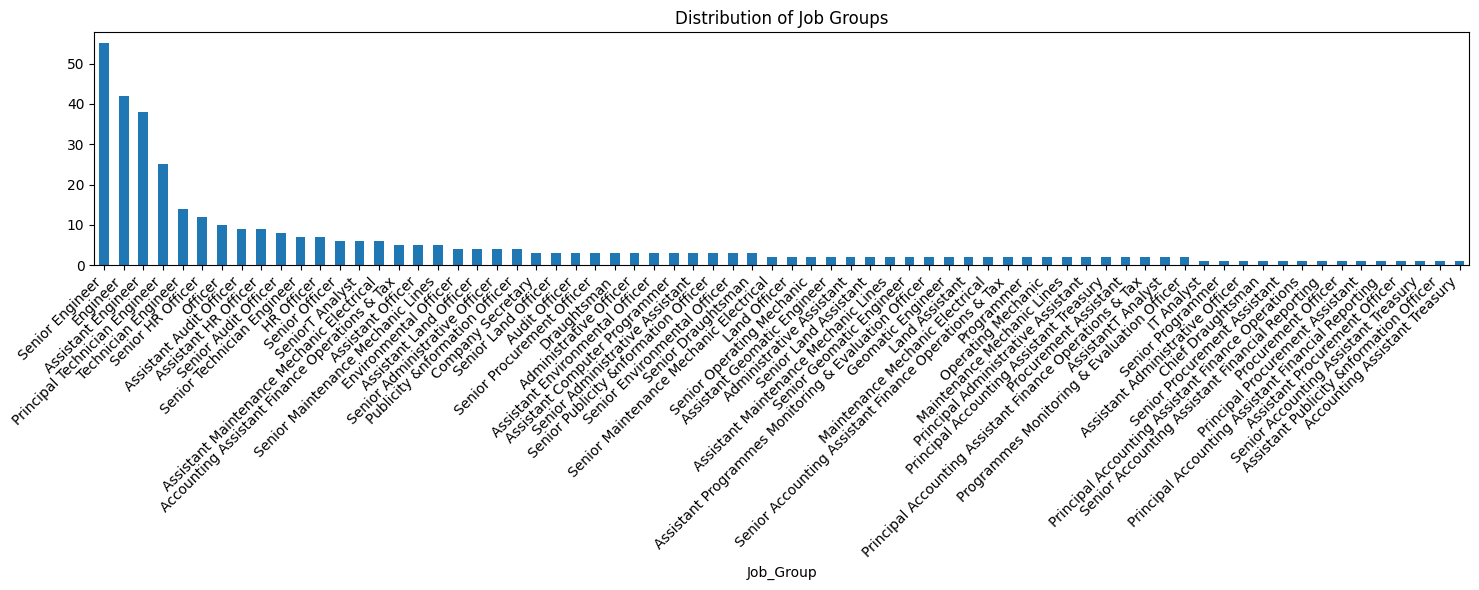

In [2]:
# Load data
train_df = pd.read_csv('training_data_combine.csv')
test_df = pd.read_csv('testing_data_combine.csv')

# Clean and group job titles
def clean_job_title(title):
    # Remove Roman numerals and special characters
    title = re.sub(r'\s+[IVX]+\s*,?', '', title)
    # Remove everything after comma
    title = title.split(',')[0].strip()
    return title

# Create job groups
train_df['Job_Group'] = train_df['Job_Title'].apply(clean_job_title)
test_df['Job_Group'] = test_df['Job_Title'].apply(clean_job_title)

# Display group statistics
print("Original number of unique job titles:", train_df['Job_Title'].nunique())
print("Number of job groups:", train_df['Job_Group'].nunique())
print("\nJob Groups and their counts:")
print(train_df['Job_Group'].value_counts())

# Visualize group distribution
plt.figure(figsize=(15, 6))
train_df['Job_Group'].value_counts().plot(kind='bar')
plt.title('Distribution of Job Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Data Augmentation

In [3]:
# Download required NLTK data
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def augment_text(text):
    augmented_texts = [text]  # Original text

    try:
        # 1. Sentence shuffling
        sentences = sent_tokenize(text)
        if len(sentences) > 1:
            shuffled = sentences.copy()
            np.random.shuffle(shuffled)
            augmented_texts.append(' '.join(shuffled))

        # 2. Simple text splitting (backup if sentence tokenization fails)
        splits = text.split('.')
        if len(splits) > 1:
            key_phrases = []
            for split in splits:
                split = split.strip()
                if any(keyword in split.lower() for keyword in ['experience', 'degree', 'qualification', 'skill']):
                    key_phrases.append(split)
            if key_phrases:
                augmented_texts.append('. '.join(key_phrases) + '.')
    except Exception as e:
        print(f"Warning: Error in augmentation: {e}")
        # Return original text if augmentation fails
        return [text]

    return augmented_texts

# Augment training data
augmented_texts = []
augmented_labels = []

print("Starting data augmentation...")
for idx, row in train_df.iterrows():
    if idx % 50 == 0:
        print(f"Processing row {idx}/{len(train_df)}")
    aug_texts = augment_text(row['Job_Info'])
    for aug_text in aug_texts:
        augmented_texts.append(aug_text)
        augmented_labels.append(row['Job_Group'])

# Create augmented DataFrame
aug_train_df = pd.DataFrame({
    'Job_Info': augmented_texts,
    'Job_Group': augmented_labels
})

print("\nAugmentation Summary:")
print("Original dataset size:", len(train_df))
print("Augmented dataset size:", len(aug_train_df))
print("\nSample of augmented data:")
print(aug_train_df.head(2))

Streaming output truncated to the last 5000 lines.
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/

## 4. Dataset Class Definition

In [4]:
class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## 5. Model and DataLoader Setup

In [5]:
# Set hyperparameters
MAX_LENGTH = 256
BATCH_SIZE = 64
EPOCHS = 70
LEARNING_RATE = 5e-5

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(aug_train_df['Job_Group'])
test_labels = label_encoder.transform(test_df['Job_Group'])

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = JobDataset(
    texts=aug_train_df['Job_Info'].values,
    labels=train_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

test_dataset = JobDataset(
    texts=test_df['Job_Info'].values,
    labels=test_labels,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.2,
)

# Move model to GPU
model.to(device)

# Initialize optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
num_training_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_training_steps // 10,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 6. Training Loop


Epoch 1/70


Validation: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Training Loss: 4.388
Validation Loss: 4.319

Epoch 2/70


Validation: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Training Loss: 4.253
Validation Loss: 4.194

Epoch 3/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Training Loss: 4.210
Validation Loss: 4.131

Epoch 4/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Training Loss: 4.080
Validation Loss: 3.963

Epoch 5/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Training Loss: 3.921
Validation Loss: 3.761

Epoch 6/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training Loss: 3.750
Validation Loss: 3.604

Epoch 7/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Training Loss: 3.603
Validation Loss: 3.423

Epoch 8/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 3.434
Validation Loss: 3.269

Epoch 9/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Training Loss: 3.273
Validation Loss: 3.141

Epoch 10/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Training Loss: 3.145
Validation Loss: 2.969

Epoch 11/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Training Loss: 2.993
Validation Loss: 2.810

Epoch 12/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 2.826
Validation Loss: 2.668

Epoch 13/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 2.681
Validation Loss: 2.521

Epoch 14/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Training Loss: 2.557
Validation Loss: 2.373

Epoch 15/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Training Loss: 2.421
Validation Loss: 2.231

Epoch 16/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training Loss: 2.327
Validation Loss: 2.138

Epoch 17/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training Loss: 2.196
Validation Loss: 2.004

Epoch 18/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


Training Loss: 2.085
Validation Loss: 1.913

Epoch 19/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


Training Loss: 1.972
Validation Loss: 1.784

Epoch 20/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 1.862
Validation Loss: 1.679

Epoch 21/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 1.755
Validation Loss: 1.580

Epoch 22/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 1.654
Validation Loss: 1.476

Epoch 23/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 1.560
Validation Loss: 1.397

Epoch 24/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


Training Loss: 1.456
Validation Loss: 1.307

Epoch 25/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Training Loss: 1.411
Validation Loss: 1.254

Epoch 26/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Training Loss: 1.328
Validation Loss: 1.173

Epoch 27/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training Loss: 1.245
Validation Loss: 1.110

Epoch 28/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


Training Loss: 1.204
Validation Loss: 1.056

Epoch 29/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Training Loss: 1.137
Validation Loss: 0.990

Epoch 30/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Training Loss: 1.084
Validation Loss: 0.958

Epoch 31/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Training Loss: 1.049
Validation Loss: 0.900

Epoch 32/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Training Loss: 0.985
Validation Loss: 0.857

Epoch 33/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Training Loss: 0.945
Validation Loss: 0.815

Epoch 34/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Training Loss: 0.906
Validation Loss: 0.786

Epoch 35/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


Training Loss: 0.881
Validation Loss: 0.743

Epoch 36/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 0.841
Validation Loss: 0.716

Epoch 37/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training Loss: 0.805
Validation Loss: 0.695

Epoch 38/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 0.777
Validation Loss: 0.662

Epoch 39/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


Training Loss: 0.747
Validation Loss: 0.640

Epoch 40/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 0.718
Validation Loss: 0.616

Epoch 41/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.33s/it]


Training Loss: 0.698
Validation Loss: 0.586

Epoch 42/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


Training Loss: 0.674
Validation Loss: 0.570

Epoch 43/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 0.647
Validation Loss: 0.546

Epoch 44/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 0.629
Validation Loss: 0.527

Epoch 45/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


Training Loss: 0.618
Validation Loss: 0.517

Epoch 46/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Training Loss: 0.598
Validation Loss: 0.498

Epoch 47/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Training Loss: 0.579
Validation Loss: 0.484

Epoch 48/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Training Loss: 0.561
Validation Loss: 0.468

Epoch 49/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Training Loss: 0.551
Validation Loss: 0.452

Epoch 50/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Training Loss: 0.547
Validation Loss: 0.444

Epoch 51/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


Training Loss: 0.512
Validation Loss: 0.431

Epoch 52/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


Training Loss: 0.505
Validation Loss: 0.420

Epoch 53/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


Training Loss: 0.500
Validation Loss: 0.408

Epoch 54/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Training Loss: 0.487
Validation Loss: 0.399

Epoch 55/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 0.482
Validation Loss: 0.394

Epoch 56/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


Training Loss: 0.469
Validation Loss: 0.382

Epoch 57/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Training Loss: 0.470
Validation Loss: 0.379

Epoch 58/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Training Loss: 0.453
Validation Loss: 0.374

Epoch 59/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]


Training Loss: 0.446
Validation Loss: 0.366

Epoch 60/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


Training Loss: 0.442
Validation Loss: 0.359

Epoch 61/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 0.445
Validation Loss: 0.356

Epoch 62/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]


Training Loss: 0.426
Validation Loss: 0.351

Epoch 63/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training Loss: 0.430
Validation Loss: 0.347

Epoch 64/70


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


Training Loss: 0.419
Validation Loss: 0.344

Epoch 65/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Training Loss: 0.417
Validation Loss: 0.342

Epoch 66/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Training Loss: 0.413
Validation Loss: 0.341

Epoch 67/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Training Loss: 0.407
Validation Loss: 0.337

Epoch 68/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Training Loss: 0.405
Validation Loss: 0.334

Epoch 69/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Training Loss: 0.408
Validation Loss: 0.333

Epoch 70/70


Validation: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Training Loss: 0.403
Validation Loss: 0.333


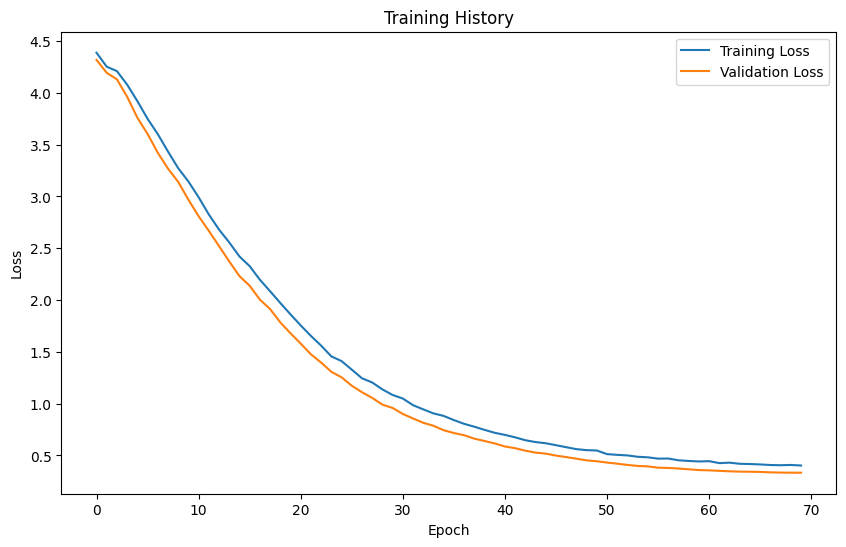

In [6]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Training with early stopping
best_val_loss = float('inf')
patience = 2
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')

    # Training
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc='Training'):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Training Loss: {avg_train_loss:.3f}')
    print(f'Validation Loss: {avg_val_loss:.3f}')

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after epoch {epoch + 1}')
            break

# Plot training history
plot_training_history(train_losses, val_losses)

## 7. Evaluation

<ipython-input-7-9a1aa0cf37f4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Evaluating: 100%|██████████| 6/6 [00:14<0


Classification Report:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Accounting Assistant Finance Operations & Tax,0.833333,1.000000,0.909091,5.000000
Accounting Assistant Treasury,0.500000,1.000000,0.666667,1.000000
Administrative Assistant,1.000000,1.000000,1.000000,2.000000
Administrative Officer,1.000000,1.000000,1.000000,3.000000
Assistant Administrative Officer,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
SeniorT Analyst,0.857143,1.000000,0.923077,6.000000
Technician Engineer,1.000000,1.000000,1.000000,14.000000
accuracy,0.970976,0.970976,0.970976,0.970976
macro avg,0.845340,0.878571,0.856117,379.000000


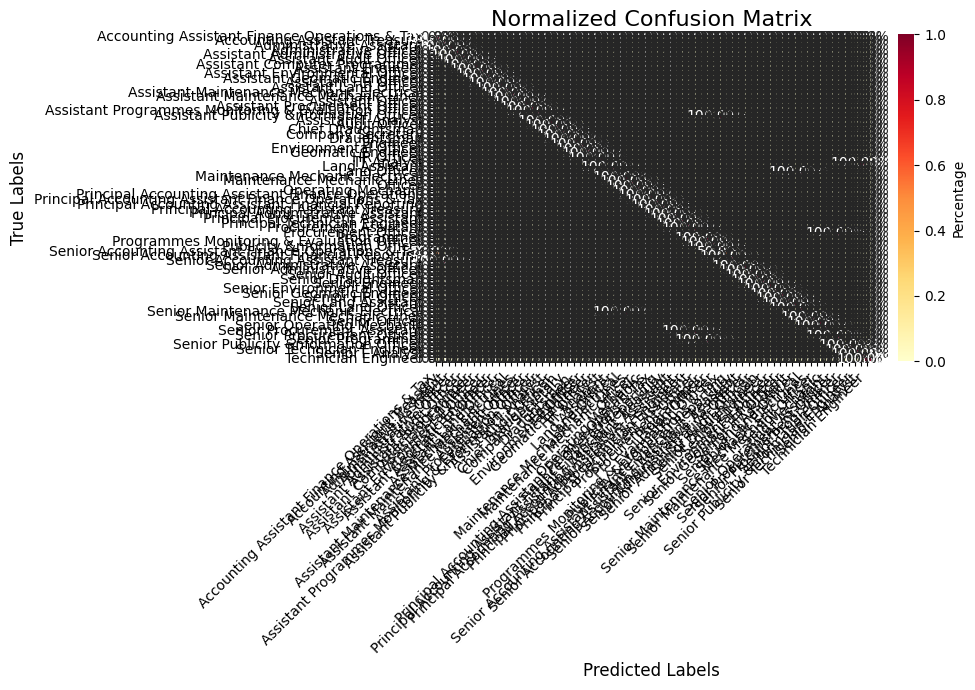

Confusion matrix heatmap saved as 'confusion_matrix_heatmap.png'


<Figure size 640x480 with 0 Axes>

In [7]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

predictions = []
actual_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

# Create classification report
report = classification_report(
    actual_labels,
    predictions,
    target_names=label_encoder.classes_,
    output_dict=True
)

# Convert to DataFrame and display
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:")
display(report_df)

# Create confusion matrix
cm = confusion_matrix(actual_labels, predictions)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the normalized confusion matrix with a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',  # Display percentages with two decimal places
    cmap='YlOrRd',  # Color scheme
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    linewidths=0.5,
    cbar_kws={'label': 'Percentage'}
)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Optionally, save the confusion matrix as an image
plt.savefig('confusion_matrix_heatmap.png', dpi=300)
print("Confusion matrix heatmap saved as 'confusion_matrix_heatmap.png'")


In [ ]:
# Load the best saved model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Function for prediction
def predict_job_group(job_info):
    # Tokenize input
    encoding = tokenizer.encode_plus(
        job_info,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Model prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

    # Decode prediction
    predicted_group = label_encoder.inverse_transform([prediction])[0]
    return predicted_group

# Interactive testing
print("\nType 'exit' to stop testing.\n")
while True:
    job_info = input("Enter a job description: ")
    if job_info.lower() == 'exit':
        break
    predicted_group = predict_job_group(job_info)
    print(f"Predicted Job Group: {predicted_group}\n")


<ipython-input-8-c9ddf659f601>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Type 'exit' to stop testing.

Enter a job description: With over five (5) years’ experience and exposure as an apprentice, a student and industrial attachment personnel, having worked under and without supervision with domestic and industrial electrical specialists, I am looking forward to make a continued and significant contribution within my chosen engineering field in Ghana and the world at large.
Predicted Job Group: Senior Engineer

Enter a job description: Solution-focused,  Good instructional skills,  Able to work collaboratively,  Serious with time and issue prioritization,  Have excellent analytical skills,
Predicted Job Group: HR Officer

Enter a job description: BSc. Electrical/Electronic Engineering;Electrical Engineer,LS • Good communication and organization skills. • Possess the ability to type and properly delve into the usage of the computer. • Proficiency in the use of Microsoft Office suite and Google workspace for documentation and presentations;Engineering Int

<ipython-input-13-c01e04417719>:25: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


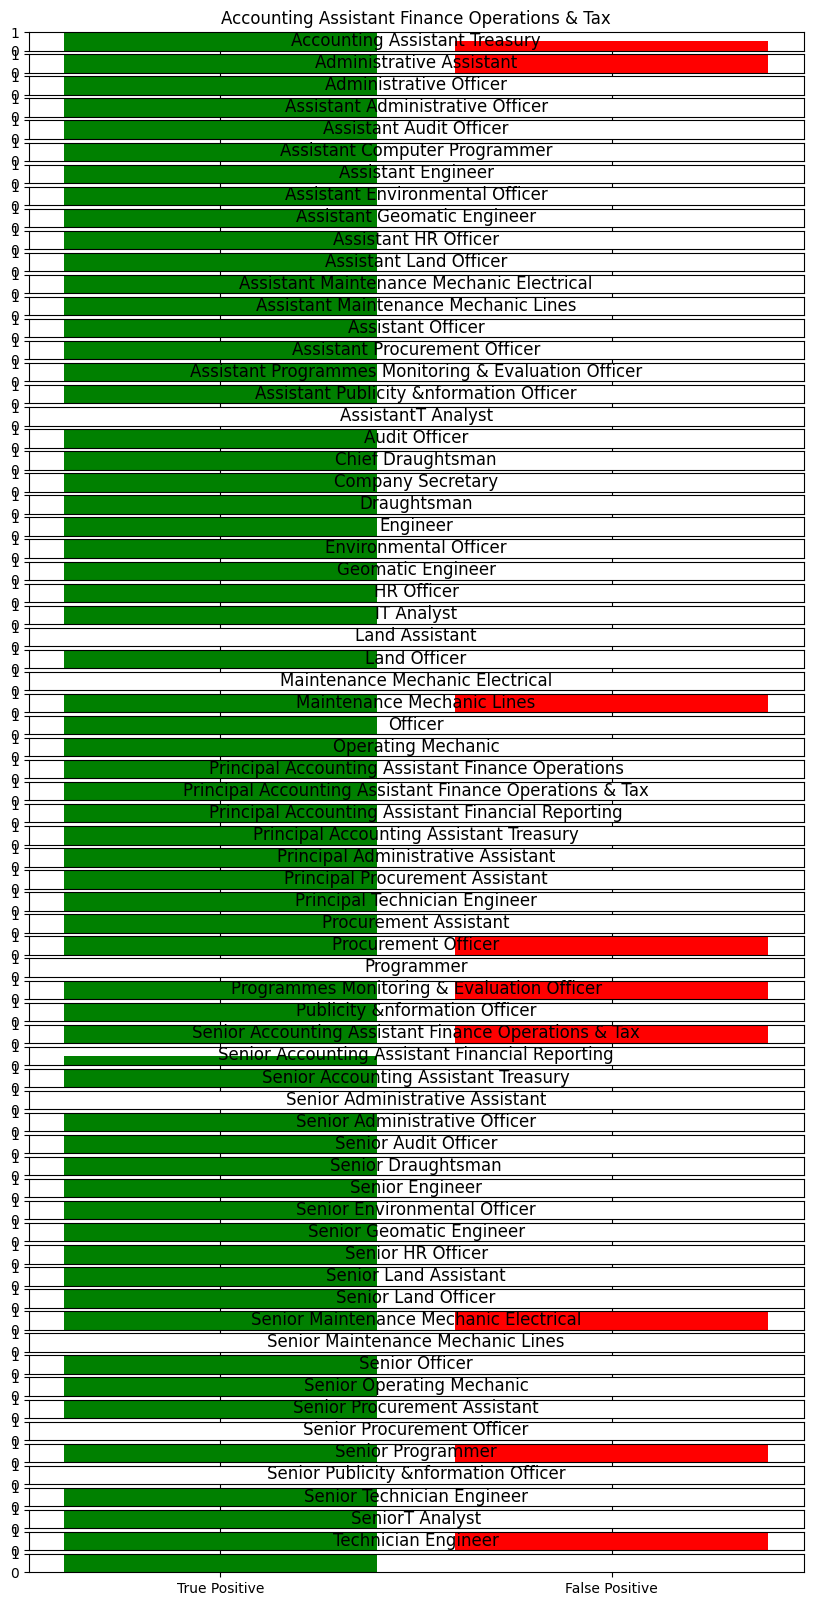

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(actual_labels, predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert the confusion matrix to DataFrame for easier handling
cm_df = pd.DataFrame(cm_normalized, index=label_encoder.classes_, columns=label_encoder.classes_)

# Create a bar chart for each class
fig, axes = plt.subplots(nrows=len(label_encoder.classes_), figsize=(10, 20))

for i, label in enumerate(label_encoder.classes_):
    ax = axes[i]
    # Extract true positive and false positive values for this class
    true_positives = cm_df.loc[label, label]
    false_positives = cm_df[label].sum() - true_positives
    # Create a bar chart for the current class
    ax.bar(['True Positive', 'False Positive'], [true_positives, false_positives], color=['green', 'red'])
    ax.set_title(f'{label}')
    ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [12]:
# Create and save confusion matrix
cm = confusion_matrix(actual_labels, predictions)

# Convert the confusion matrix to a DataFrame
cm_df = pd.DataFrame(
    cm,
    index=label_encoder.classes_,  # True labels
    columns=label_encoder.classes_  # Predicted labels
)

# Save to a CSV file
cm_df.to_csv('confusion_matrix.csv', index=True)

print("Confusion matrix saved as 'confusion_matrix.csv'")


Confusion matrix saved as 'confusion_matrix.csv'


In [14]:
import pickle

# Assuming 'label_encoder' is already fitted
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


In [17]:
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support,
    accuracy_score
)
from tqdm import tqdm

# Load test dataset (ensure `test_loader` is defined as in the training script)
test_labels = []  # True labels
pred_labels = []  # Predicted labels
probs = []        # Predicted probabilities for each class

# Evaluate the model
print("Evaluating the model...")
model.eval()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=1)

        # Append results
        probs.extend(softmax_probs.cpu().numpy())
        pred_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
probs = np.array(probs)
test_labels = np.array(test_labels)
pred_labels = np.array(pred_labels)

# Calculate AUROC (one-vs-rest)
auroc = roc_auc_score(test_labels, probs, multi_class='ovr')

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

# Sensitivity, Specificity, Precision, Recall, F1-score
tn, fp, fn, tp = conf_matrix.ravel()  # Only works for binary classification
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, pred_labels, average='weighted')

print("\nMetrics:")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUROC: {auroc:.4f}")

# Plot ROC Curve (one-vs-rest)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, probs[:, i])
    roc_auc[i] = roc_auc_score(test_labels == i, probs[:, i])

plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUROC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Evaluating the model...


Testing: 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


Classification Report:
                                                         precision    recall  f1-score   support

          Accounting Assistant Finance Operations & Tax       0.83      1.00      0.91         5
                          Accounting Assistant Treasury       0.50      1.00      0.67         1
                               Administrative Assistant       1.00      1.00      1.00         2
                                 Administrative Officer       1.00      1.00      1.00         3
                       Assistant Administrative Officer       1.00      1.00      1.00         1
                                Assistant Audit Officer       1.00      1.00      1.00         9
                          Assistant Computer Programmer       1.00      1.00      1.00         3
                                     Assistant Engineer       1.00      1.00      1.00        38
                        Assistant Environmental Officer       1.00      1.00      1.00         3
     


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: too many values to unpack (expected 4)